In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm

## Initialisation

In [2]:
def convert_date1(date_bytes):
    return mdates.strpdate2num('%H%M%S%f')(date_bytes.decode('ascii'))

def convert_date0(date_bytes):
    return mdates.strpdate2num('%y%m%d')(date_bytes.decode('ascii'))


datafile = '2014-03-26-000-Data.csv'

_, _, _, ax, ay, az, _, _, yawrate, _, _, _, speed, course, latitude, longitude, altitude, _, _, _, _, _, _, _, _ \
= np.loadtxt(datafile, delimiter=',', unpack=True, 
                  converters={1: convert_date1,
                              0: convert_date0},
                  skiprows=1)

print('Read \'%s\' successfully.' % datafile)

course =(-course+90.0)
yawrate = yawrate/180.0*np.pi

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The strpdate2num class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use time.strptime or dateutil.parser.parse or datestr2num instead.
  """
C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The strpdate2num class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use time.strptime or dateutil.parser.parse or datestr2num instead.
  


Read '2014-03-26-000-Data.csv' successfully.


In [3]:
RadiusEarth = 6378388.0 # m
arc= 2.0*np.pi*(RadiusEarth+altitude)/360.0 # m/°

dx = arc * np.cos(latitude*np.pi/180.0) * np.hstack((0.0, np.diff(longitude))) # in m
dy = arc * np.hstack((0.0, np.diff(latitude))) # in m

mx = np.cumsum(dx)
my = np.cumsum(dy)

ds = np.sqrt(dx**2+dy**2)

GPS=(ds!=0.0).astype('bool') # GPS Trigger for Kalman Filter
acceleration = np.sqrt(ax**2 + ay**2)

In [4]:
x = np.matrix([[mx[0], my[0], course[0]/180.0*np.pi, speed[0]/3.6+0.001, acceleration[0]/12.96+0.001 , yawrate[0]/180.0*np.pi]]).T
measurements = np.vstack((mx, my, course/180.0*np.pi, speed/3.6, acceleration/3.6, yawrate))
m = measurements.shape[1]

In [5]:
dt = 1/50

In [6]:
varGPS = 0.5
varspeed = 3.0 
varyaw = 0.1 
varacc = 1.0 # Variances on sensor from tests. To be changed for the car when we have the sensors
R = np.diag([varGPS**2, varGPS**2, varyaw**2, varspeed**2, varacc**2, varyaw**2])
I = np.eye(6)

In [7]:
P = np.diag([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

sGPS     = 0.5*8.8*dt**2  
sCourse  = 0.1*dt 
sVelocity= 8.8*dt 
sYawrate     = 1.0*dt # Again, to be changed

Q = np.diag([sGPS**2, sGPS**2, sCourse**2, sVelocity**2, sVelocity**2, sYawrate**2])

In [8]:
thresholdGPS = 10
thresholdCourse = 0.5

thresholdVelocity = 5
thresholdAcceleration = 1
thresholdYawrate = 0.1

In [9]:
def euclidean_distance(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2 +(y1-y2)**2)

In [10]:
def detect_failure(x, data):
    valid_data = []
    
    deltaGPS = euclidean_distance(x[0],x[1],data[0],data[1])
    valid_data.append(1.0 if deltaGPS<thresholdGPS else 0.0)

    deltaCourse = min(np.abs(x[2] - data[2]), np.abs(np.mod(x[2], 2*np.pi) - np.mod(data[2], 2*np.pi)))
    valid_data.append(1.0 if deltaCourse<thresholdCourse else 0.0)
    
    deltaVelocity = np.abs(x[3] - data[3])
    deltaAcceleration = np.abs(x[4] - data[4])
    deltaYawrate = np.abs(x[5] - data[5])
    
    valid_data.append(1.0 if deltaVelocity<thresholdVelocity else 0.0)
    valid_data.append(1.0 if deltaAcceleration<thresholdAcceleration else 0.0)
    valid_data.append(1.0 if deltaYawrate<thresholdYawrate else 0.0)
    
    return valid_data

## Kalman Filter

In [11]:
# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []

In [12]:
def kalman_update(x, data, P, Q, R, I, dt, init):
    
    #x0 is x, x1 is y, x2 is heading, x3 is velocity, x4 is acceleration, x5 is yaw rate
    
    ux = (1/x[5]**2) * \
 ((x[3]*x[5] + x[4]*x[5]*dt)* \
  np.sin(x[2] + x[5]*dt) + x[4]*np.cos(x[2] + x[5]*dt) - x[3]*x[5]*np.sin(x[2]) - np.cos(x[2])*x[4])
    uy = (1/x[5]**2) * \
 ((-x[3]*x[5] - x[4]*x[5]*dt)* np.cos(x[2] + x[5]*dt) \
 + x[4]*np.sin(x[2] + x[5]*dt) + x[3]*x[5]*np.cos(x[2]) - x[4]*np.sin(x[2]))


    x[0] = x[0] + ux
    x[1] = x[1] + uy
    x[2] = x[2] + dt*x[5]
    x[3] = x[3] + dt*x[4]
    x[4] = x[4]
    x[5] = x[5]
    
    a13 = float((1/x[5]**2) * (x[4]*np.sin(x[2])- x[4]*np.sin(dt*x[5]+x[2]) - x[3]*x[5]*np.cos(x[2]) + (dt*x[4]*x[5] + x[3]*x[5])*np.cos(dt*x[5]+x[2]))) 
    a23 = float((1/x[5]**2) * (-x[4]*np.cos(x[2])+ x[4]*np.cos(dt*x[5]+x[2]) - x[3]*x[5]*np.sin(x[2]) - (-dt*x[4]*x[5] - x[3]*x[5])*np.sin(dt*x[5]+x[2]))) 
    
    a14 = float((1/x[5]**2) * (-x[5]*np.sin(x[2]) + x[5]*np.sin(dt*x[5]+x[2])))
    a24 = float((1/x[5]**2) * (x[5]*np.cos(x[2]) - x[5]*np.cos(dt*x[5]+x[2])))
    
    a15 = float((1/x[5]**2) * (dt*x[5]*np.sin(dt*x[5]+x[2])-np.cos(x[2])+np.cos(dt*x[5] + x[2])))
    a25 = float((1/x[5]**2) * (-dt*x[5]*np.cos(dt*x[5]+x[2])-np.sin(x[2])+np.sin(dt*x[5] + x[2])))
    
    a161 = float((1/x[5]**2) * (-dt*x[4]*np.sin(dt*x[5]+x[2])+dt*(dt*x[4]*x[5]+x[3]*x[5])*np.cos(dt*x[5]+x[2])-x[3]*np.sin(x[2])+(dt*x[4]+x[3])*np.sin(dt*x[5]+x[2])))
    a162 = float((1/x[5]**3) * (-x[4]*np.cos(x[2])+x[4]*np.cos(dt*x[5]+x[2])-x[3]*x[5]*np.sin(x[2])+(dt*x[4]*x[5]+x[3]*x[5])*np.sin(dt*x[5]+x[2])))
    a16 = a161-2*a162
    
    a261 = float((1/x[5]**2) * (dt*x[4]*np.cos(dt*x[5]+x[2])-dt*(-dt*x[4]*x[5]-[3]*x[5])*np.sin(dt*x[5]+x[2])+x[3]*np.cos(x[2])+(-dt*x[4]-x[3])*np.cos(dt*x[5]+x[2])))
    a262 = float((1/x[5]**3) * (-x[4]*np.sin(x[2])+x[4]*np.sin(dt*x[5]+x[2])+x[3]*x[5]*np.cos(x[2])+(-dt*x[4]*x[5]-x[3]*x[5])*np.cos(dt*x[5]+x[2])))
    a26 = a161-2*a162


    Jf = np.matrix([[1.0, 0.0, a13, a14, a15, a16],
                    [0.0, 1.0, a23, a24, a25, a26],
                    [0.0, 0.0, 1.0, 0.0, 0.0, dt],
                    [0.0, 0.0, 0.0, 1.0, dt, 0.0], 
                    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0], 
                    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
    
    
    # Project the error covariance ahead
    P = Jf*P*Jf.T + Q
    
    # Measurement Update (Correction)
    # ===============================
    # Measurement Function
    hx = np.matrix([[float(x[0])],
                    [float(x[1])],
                    [float(x[2])],
                    [float(x[3])],
                    [float(x[4])],
                    [float(x[5])]])
    
    
    if GPS[filterstep]:
        if init:
            Jh = np.diag([1.0,1.0,1.0,1.0,1.0,1.0])
        else:
            valid_data = detect_failure(x, data)
            Jh = np.diag([valid_data[0],valid_data[0],valid_data[1],valid_data[2],valid_data[3],valid_data[4]])
    else:
        if init:
            Jh = np.diag([0.0,0.0,1.0,1.0,1.0,1.0])
        else:
            valid_data = detect_failure(x, data)
            Jh = np.diag([0,0,valid_data[1],valid_data[2],valid_data[3],valid_data[4]])

          
    K = (P*Jh.T) * np.linalg.inv(Jh*P*Jh.T + R)

    # Update the estimate via
    Z = data.reshape(Jh.shape[0],1)
    y = Z - (hx)
    x = x + (K*y)

    # Update the error covariance
    P = (I - (K*Jh))*P
    
    return (x, P)

In [13]:
for filterstep in tqdm(range(m)):

    data = measurements[:,filterstep]
    init = True if filterstep<100 else False
    
    x, P = kalman_update(x, data, P, Q, R, I, dt, init)

    # Save states for Plotting
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    x5.append(float(x[5]))

100%|██████████| 10800/10800 [00:21<00:00, 503.47it/s]


## Plotting

(-40.727931165614564,
 635.2150697044904,
 -28.41336169764915,
 361.48783237371646)

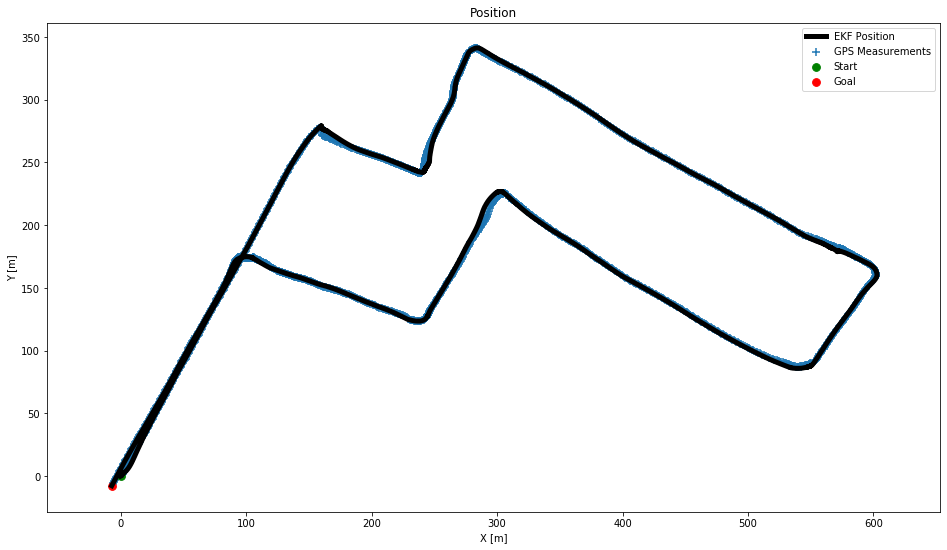

In [14]:
n = 10800
xn = x0[:n]
yn = x1[:n]
hn= x2[:n]

fig = plt.figure(figsize=(16,9))

# EKF State
plt.quiver(xn,yn,np.cos(hn), np.sin(hn), color='#94C600', units='xy', width=0.05, scale=0.5)
plt.plot(xn,yn, label='EKF Position', c='k', lw=5)

# Measurements
plt.scatter(mx[::5],my[::5], s=50, label='GPS Measurements', marker='+')

# Start/Goal
plt.scatter(x0[0],x1[0], s=60, label='Start', c='g')
plt.scatter(x0[-1],x1[-1], s=60, label='Goal', c='r')

plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Position')
plt.legend(loc='best')
plt.axis('equal')

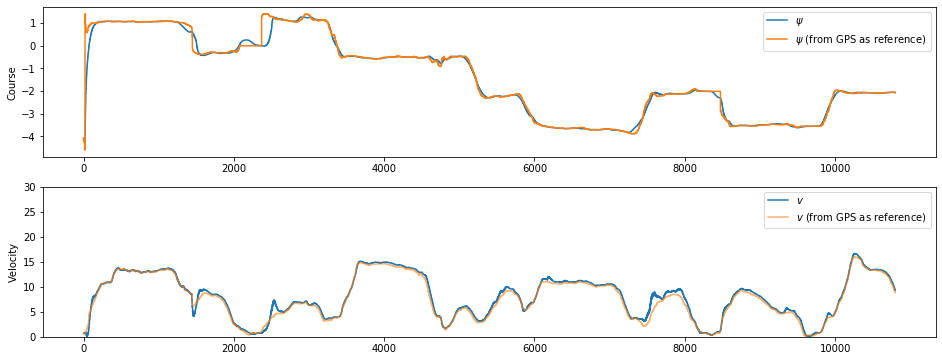

In [15]:
fig = plt.figure(figsize=(16,16))
plt.subplot(512)
plt.step(range(len(measurements[0])),x2, label='$\psi$')
plt.step(range(len(measurements[0])),(course/180.0*np.pi), label='$\psi$ (from GPS as reference)')
plt.ylabel('Course')
plt.legend(loc='best')
           
plt.subplot(513)
plt.step(range(len(measurements[0])),x3, label='$v$')
plt.step(range(len(measurements[0])),speed/3.6, label='$v$ (from GPS as reference)', alpha=0.6)
plt.ylabel('Velocity')
plt.ylim([0, 30])
plt.legend(loc='best')